In [101]:
import pymc as pm
from scipy.stats import bernoulli, beta, norm, uniform
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as stats
import scipy
import os
import pandas as pd
import seaborn as sns
from scipy import special, stats
from google.colab import files
from google.colab import drive
from sklearn.preprocessing import StandardScaler, scale

In [102]:
az.style.use("arviz-darkgrid")
random_seed = 6040

In [103]:
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
# import dataset
sleep = pd.read_csv('sleep.csv')

sleep

,Person_ID,Gender,Age,Occupation,Sleep_Duration,Sleep_Quality,Physical_Activity_Level,Stress_Level,BMI_Category,Blood_Pressure,Heart_Rate,Daily_Steps,Sleep_Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


In [105]:
# convert object to category
for col in ['Gender', 'Occupation', 'BMI_Category', 'Blood_Pressure', 'Sleep_Disorder']:
    sleep[col] = sleep[col].astype('category')

In [106]:
# Select numerical columns
numerical_columns = sleep.select_dtypes(include=['float64', 'int64']).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected numerical columns
sleep[numerical_columns] = scaler.fit_transform(sleep[numerical_columns])
sleep.head()

,Person_ID,Gender,Age,Occupation,Sleep_Duration,Sleep_Quality,Physical_Activity_Level,Stress_Level,BMI_Category,Blood_Pressure,Heart_Rate,Daily_Steps,Sleep_Disorder
0,-1.727426,Male,-1.753096,Software Engineer,-1.298887,-1.098280,-0.825418,0.347021,Overweight,126/83,1.654719,-1.619584,None
1,-1.718163,Male,-1.637643,Doctor,-1.173036,-1.098280,0.039844,1.475592,Normal,125/80,1.170474,1.970077,None
2,-1.708901,Male,-1.637643,Doctor,-1.173036,-1.098280,0.039844,1.475592,Normal,125/80,1.170474,1.970077,None
3,-1.699639,Male,-1.637643,Sales Representative,-1.550588,-2.771424,-1.402260,1.475592,Obese,140/90,3.591698,-2.362273,Sleep Apnea
4,-1.690376,Male,-1.637643,Sales Representative,-1.550588,-2.771424,-1.402260,1.475592,Obese,140/90,3.591698,-2.362273,Sleep Apnea


In [107]:
# coding blood pressure as categorical variable
sleep[['Systolic_BP', 'Diastolic_BP']] = sleep['Blood_Pressure'].str.split('/', expand=True).astype(int)

# define conditions and corresponding categories
conditions = [
    (sleep['Systolic_BP'] < 120) & (sleep['Diastolic_BP'] < 80),
    (sleep['Systolic_BP'].between(120, 129)) & (sleep['Diastolic_BP'] < 80),
    (sleep['Systolic_BP'].between(130, 139)) | (sleep['Diastolic_BP'].between(80, 89)),
    (sleep['Systolic_BP'] >= 140) | (sleep['Diastolic_BP'] >= 90),
    (sleep['Systolic_BP'] >= 180) | (sleep['Diastolic_BP'] >= 120)
]

categories = ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis']

# create a new column 'BP_Category' based on the conditions
sleep['BP_Category'] = np.select(conditions, categories)

sleep['Sleep_Disorder'] = sleep['Sleep_Disorder'].map(lambda x: 0 if x == 'None' else 1) # 1: sleep disorder; 0: none

sleep.head()

,Person_ID,Gender,Age,Occupation,Sleep_Duration,Sleep_Quality,Physical_Activity_Level,Stress_Level,BMI_Category,Blood_Pressure,Heart_Rate,Daily_Steps,Sleep_Disorder,Systolic_BP,Diastolic_BP,BP_Category
0,-1.727426,Male,-1.753096,Software Engineer,-1.298887,-1.098280,-0.825418,0.347021,Overweight,126/83,1.654719,-1.619584,0,126,83,Hypertension Stage 1
1,-1.718163,Male,-1.637643,Doctor,-1.173036,-1.098280,0.039844,1.475592,Normal,125/80,1.170474,1.970077,0,125,80,Hypertension Stage 1
2,-1.708901,Male,-1.637643,Doctor,-1.173036,-1.098280,0.039844,1.475592,Normal,125/80,1.170474,1.970077,0,125,80,Hypertension Stage 1
3,-1.699639,Male,-1.637643,Sales Representative,-1.550588,-2.771424,-1.402260,1.475592,Obese,140/90,3.591698,-2.362273,1,140,90,Hypertension Stage 2
4,-1.690376,Male,-1.637643,Sales Representative,-1.550588,-2.771424,-1.402260,1.475592,Obese,140/90,3.591698,-2.362273,1,140,90,Hypertension Stage 2


<ipython-input-108-c72fb9feabc5>:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjusts the plot layout


<Figure size 800x1000 with 0 Axes>

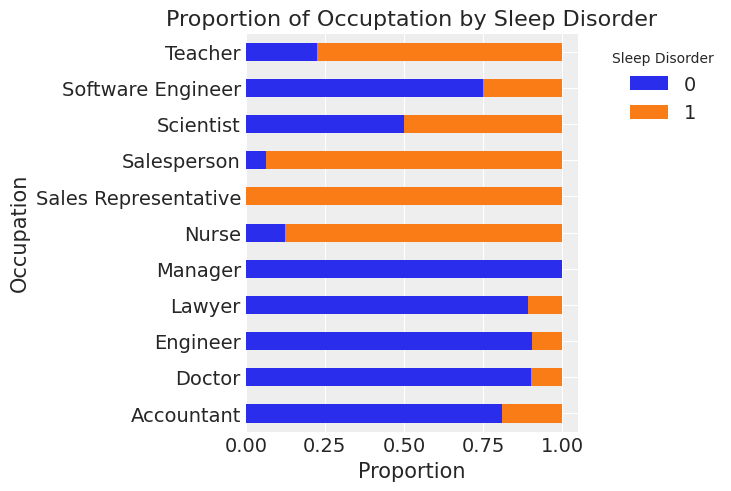

In [108]:
# Normalize data to represent proportions
normalized_data = pd.crosstab(sleep['Occupation'], sleep['Sleep_Disorder'], normalize='index')

# Plotting normalized data as a horizontal stacked bar plot
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed
normalized_data.plot(kind='barh', stacked=True)
plt.title('Proportion of Occuptation by Sleep Disorder')
plt.xlabel('Proportion')
plt.ylabel('Occupation')

# Adjusting legend position
plt.legend(title='Sleep Disorder', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjusts the plot layout
plt.show()


<ipython-input-109-7de930ff6bae>:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjusts the plot layout


<Figure size 800x1000 with 0 Axes>

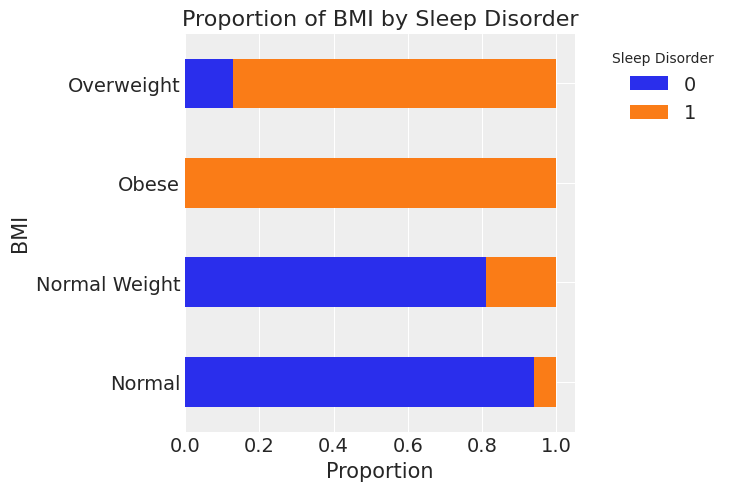

In [109]:
# Normalize data to represent proportions
normalized_data = pd.crosstab(sleep['BMI_Category'], sleep['Sleep_Disorder'], normalize='index')

# Plotting normalized data as a horizontal stacked bar plot
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed
normalized_data.plot(kind='barh', stacked=True)
plt.title('Proportion of BMI by Sleep Disorder')
plt.xlabel('Proportion')
plt.ylabel('BMI')

# Adjusting legend position
plt.legend(title='Sleep Disorder', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjusts the plot layout
plt.show()

<ipython-input-110-a965ea899e0e>:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjusts the plot layout


<Figure size 800x1000 with 0 Axes>

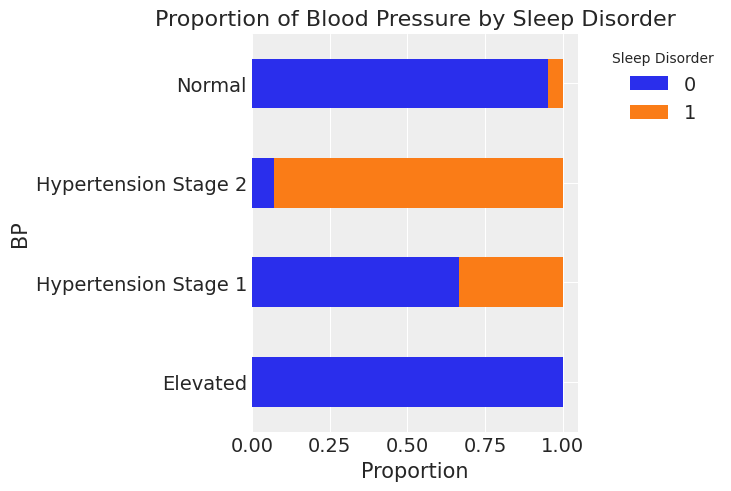

In [110]:
# Normalize data to represent proportions
normalized_data = pd.crosstab(sleep['BP_Category'], sleep['Sleep_Disorder'], normalize='index')

# Plotting normalized data as a horizontal stacked bar plot
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed
normalized_data.plot(kind='barh', stacked=True)
plt.title('Proportion of Blood Pressure by Sleep Disorder')
plt.xlabel('Proportion')
plt.ylabel('BP')

# Adjusting legend position
plt.legend(title='Sleep Disorder', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjusts the plot layout
plt.show()

<ipython-input-111-f9ceccbe4a5b>:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjusts the plot layout


<Figure size 800x1000 with 0 Axes>

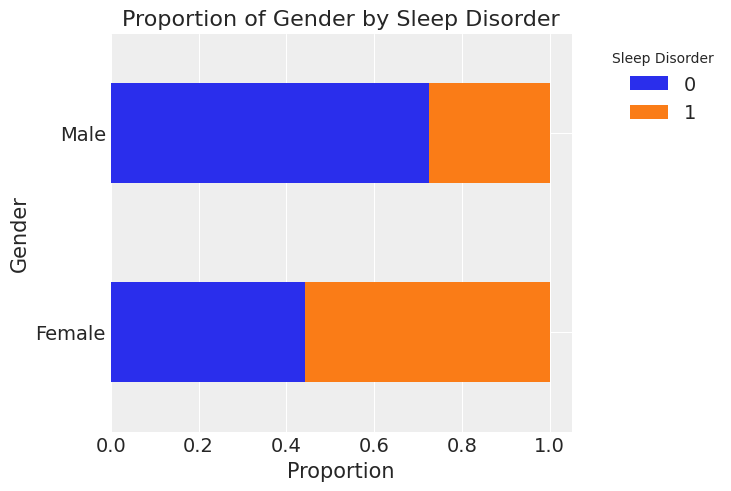

In [111]:
# Normalize data to represent proportions
normalized_data = pd.crosstab(sleep['Gender'], sleep['Sleep_Disorder'], normalize='index')

# Plotting normalized data as a horizontal stacked bar plot
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed
normalized_data.plot(kind='barh', stacked=True)
plt.title('Proportion of Gender by Sleep Disorder')
plt.xlabel('Proportion')
plt.ylabel('Gender')

# Adjusting legend position
plt.legend(title='Sleep Disorder', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjusts the plot layout
plt.show()

In [112]:
# one-hot coding for categorical variables
sleep['Gender'] = pd.factorize(sleep['Gender'])[0]

sleep['Occupation'] = pd.factorize(sleep['Occupation'])[0]

sleep['BMI_Category'] = pd.factorize(sleep['BMI_Category'])[0]

sleep['BP_Category'] = pd.factorize(sleep['BP_Category'])[0]

sleep.head()

,Person_ID,Gender,Age,Occupation,Sleep_Duration,Sleep_Quality,Physical_Activity_Level,Stress_Level,BMI_Category,Blood_Pressure,Heart_Rate,Daily_Steps,Sleep_Disorder,Systolic_BP,Diastolic_BP,BP_Category
0,-1.727426,0,-1.753096,0,-1.298887,-1.098280,-0.825418,0.347021,0,126/83,1.654719,-1.619584,0,126,83,0
1,-1.718163,0,-1.637643,1,-1.173036,-1.098280,0.039844,1.475592,1,125/80,1.170474,1.970077,0,125,80,0
2,-1.708901,0,-1.637643,1,-1.173036,-1.098280,0.039844,1.475592,1,125/80,1.170474,1.970077,0,125,80,0
3,-1.699639,0,-1.637643,2,-1.550588,-2.771424,-1.402260,1.475592,2,140/90,3.591698,-2.362273,1,140,90,1
4,-1.690376,0,-1.637643,2,-1.550588,-2.771424,-1.402260,1.475592,2,140/90,3.591698,-2.362273,1,140,90,1


In [113]:
# finalize and sort the dataset
selected_columns = ['Gender', 'Age', 'Occupation', 'Sleep_Duration', 'Sleep_Quality', 'Physical_Activity_Level',
                    'Stress_Level', 'BMI_Category', 'Heart_Rate', 'Daily_Steps', 'BP_Category', 'Sleep_Disorder']

df = sleep[selected_columns]

In [114]:
df.head()

,Gender,Age,Occupation,Sleep_Duration,Sleep_Quality,Physical_Activity_Level,Stress_Level,BMI_Category,Heart_Rate,Daily_Steps,BP_Category,Sleep_Disorder
0,0,-1.753096,0,-1.298887,-1.098280,-0.825418,0.347021,0,1.654719,-1.619584,0,0
1,0,-1.637643,1,-1.173036,-1.098280,0.039844,1.475592,1,1.170474,1.970077,0,0
2,0,-1.637643,1,-1.173036,-1.098280,0.039844,1.475592,1,1.170474,1.970077,0,0
3,0,-1.637643,2,-1.550588,-2.771424,-1.402260,1.475592,2,3.591698,-2.362273,1,1
4,0,-1.637643,2,-1.550588,-2.771424,-1.402260,1.475592,2,3.591698,-2.362273,1,1


In [115]:
#EDA
columns_to_visualize = ['Sleep_Disorder', 'Age', 'Sleep_Duration', 'Sleep_Quality',
                        'Physical_Activity_Level', 'Stress_Level', 'Heart_Rate', 'Daily_Steps']

df_melted = df.melt(id_vars='Sleep_Disorder', value_vars=columns_to_visualize, var_name='Variable', value_name='Value')
df_melted

,Sleep_Disorder,Variable,Value
0,0,Age,-1.753096
1,0,Age,-1.637643
2,0,Age,-1.637643
3,1,Age,-1.637643
4,1,Age,-1.637643
...,...,...,...
2613,1,Daily_Steps,0.113356
2614,1,Daily_Steps,0.113356
2615,1,Daily_Steps,0.113356
2616,1,Daily_Steps,0.113356


<ipython-input-116-7822f02218ac>:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


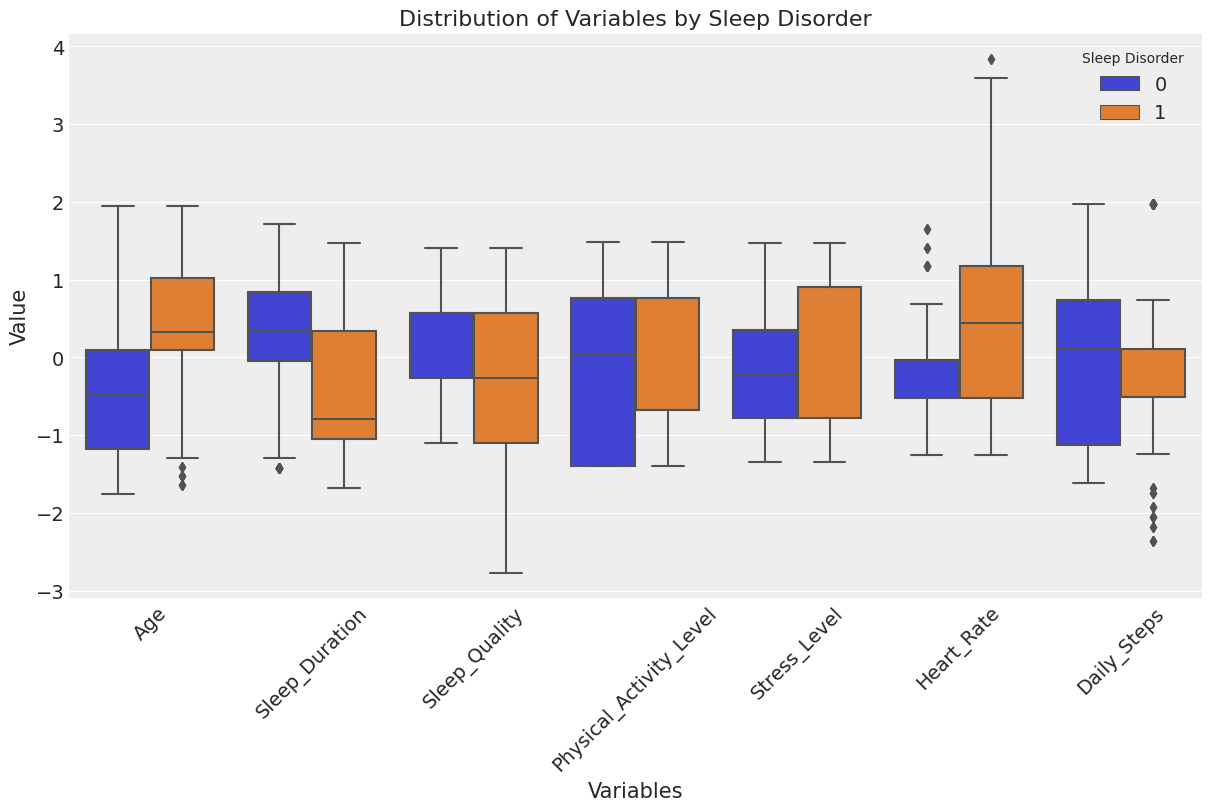

In [116]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_melted, x='Variable', y='Value', hue='Sleep_Disorder')
plt.title('Distribution of Variables by Sleep Disorder')
plt.xlabel('Variables')
plt.ylabel('Value')
plt.legend(title='Sleep Disorder')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

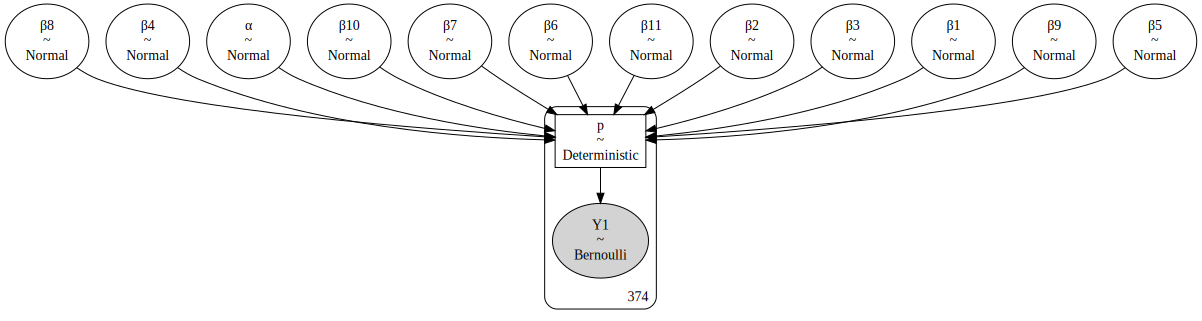

In [117]:
#main effects model
with pm.Model() as main_eff_model:
    Y = df["Sleep_Disorder"]
    α = pm.Normal('α', mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    β3 = pm.Normal('β3', mu=0, sigma=10)
    β4 = pm.Normal('β4', mu=0, sigma=10)
    β5 = pm.Normal('β5', mu=0, sigma=10)
    β6 = pm.Normal('β6', mu=0, sigma=10)
    β7 = pm.Normal('β7', mu=0, sigma=10)
    β8 = pm.Normal('β8', mu=0, sigma=10)
    β9 = pm.Normal('β9', mu=0, sigma=10)
    β10 = pm.Normal('β10', mu=0, sigma=10)
    β11 = pm.Normal('β11', mu=0, sigma=10)

    mu = α+β1*df["Age"]+β2*df['Occupation']+β3*df["Sleep_Duration"]+β4*df["Sleep_Quality"]+β5*df["Physical_Activity_Level"]+β6*df["Stress_Level"]+β7*df["BMI_Category"]+β8*df["Heart_Rate"]+β9*df["Daily_Steps"]+β10*df["BP_Category"]+β11*df["Gender"]

    p = pm.Deterministic('p', pm.invlogit(mu))

    Y1 = pm.Bernoulli('Y1', p=p, observed=Y)

pm.model_to_graphviz(main_eff_model)

In [118]:
## prior predictive check
sleep_ppc = pm.sample_prior_predictive(model = main_eff_model)

<Axes: >

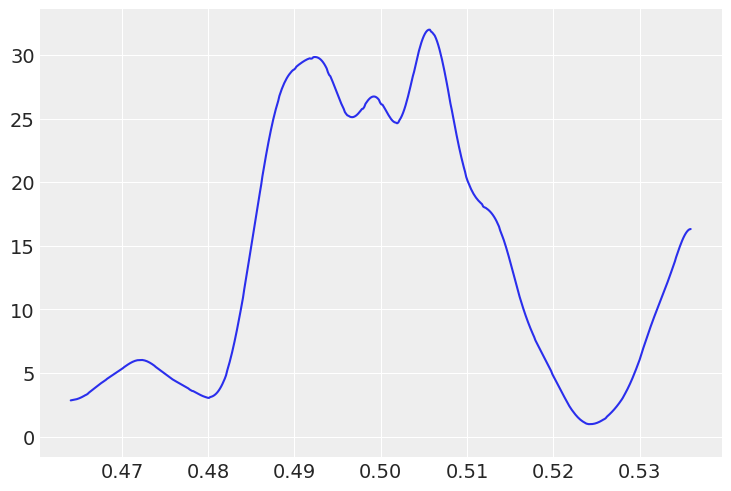

In [119]:
az.plot_dist(sleep_ppc.prior_predictive['Y1'].mean(dim=['chain','draw']))

<Axes: >

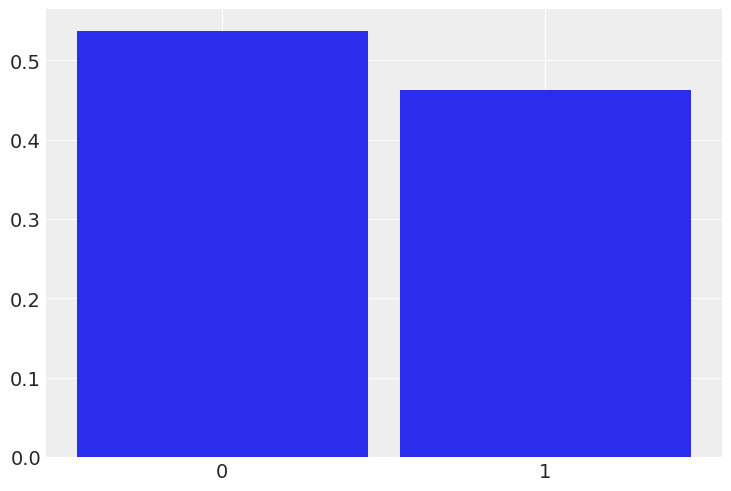

In [120]:
# Predicted sleep disorder

# Define a threshold (e.g., 0.4)
threshold = 0.5

# Convert probabilities to binary using the threshold
binary_output = (sleep_ppc.prior_predictive['Y1'].mean(dim=['chain','draw']) > threshold).astype(int)

# Plot the distribution of binary output
az.plot_dist(binary_output)

<Axes: >

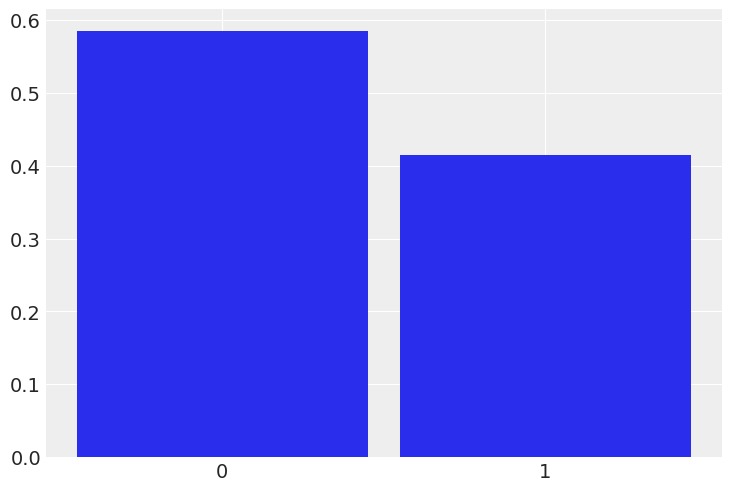

In [121]:
# Observed sleep
az.plot_dist(sleep_ppc.observed_data['Y1'])

In [122]:
# Sample to get posterior
with main_eff_model:
    sleep_trace = pm.sample(1000, tune=2000, random_seed=random_seed, cores=8)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


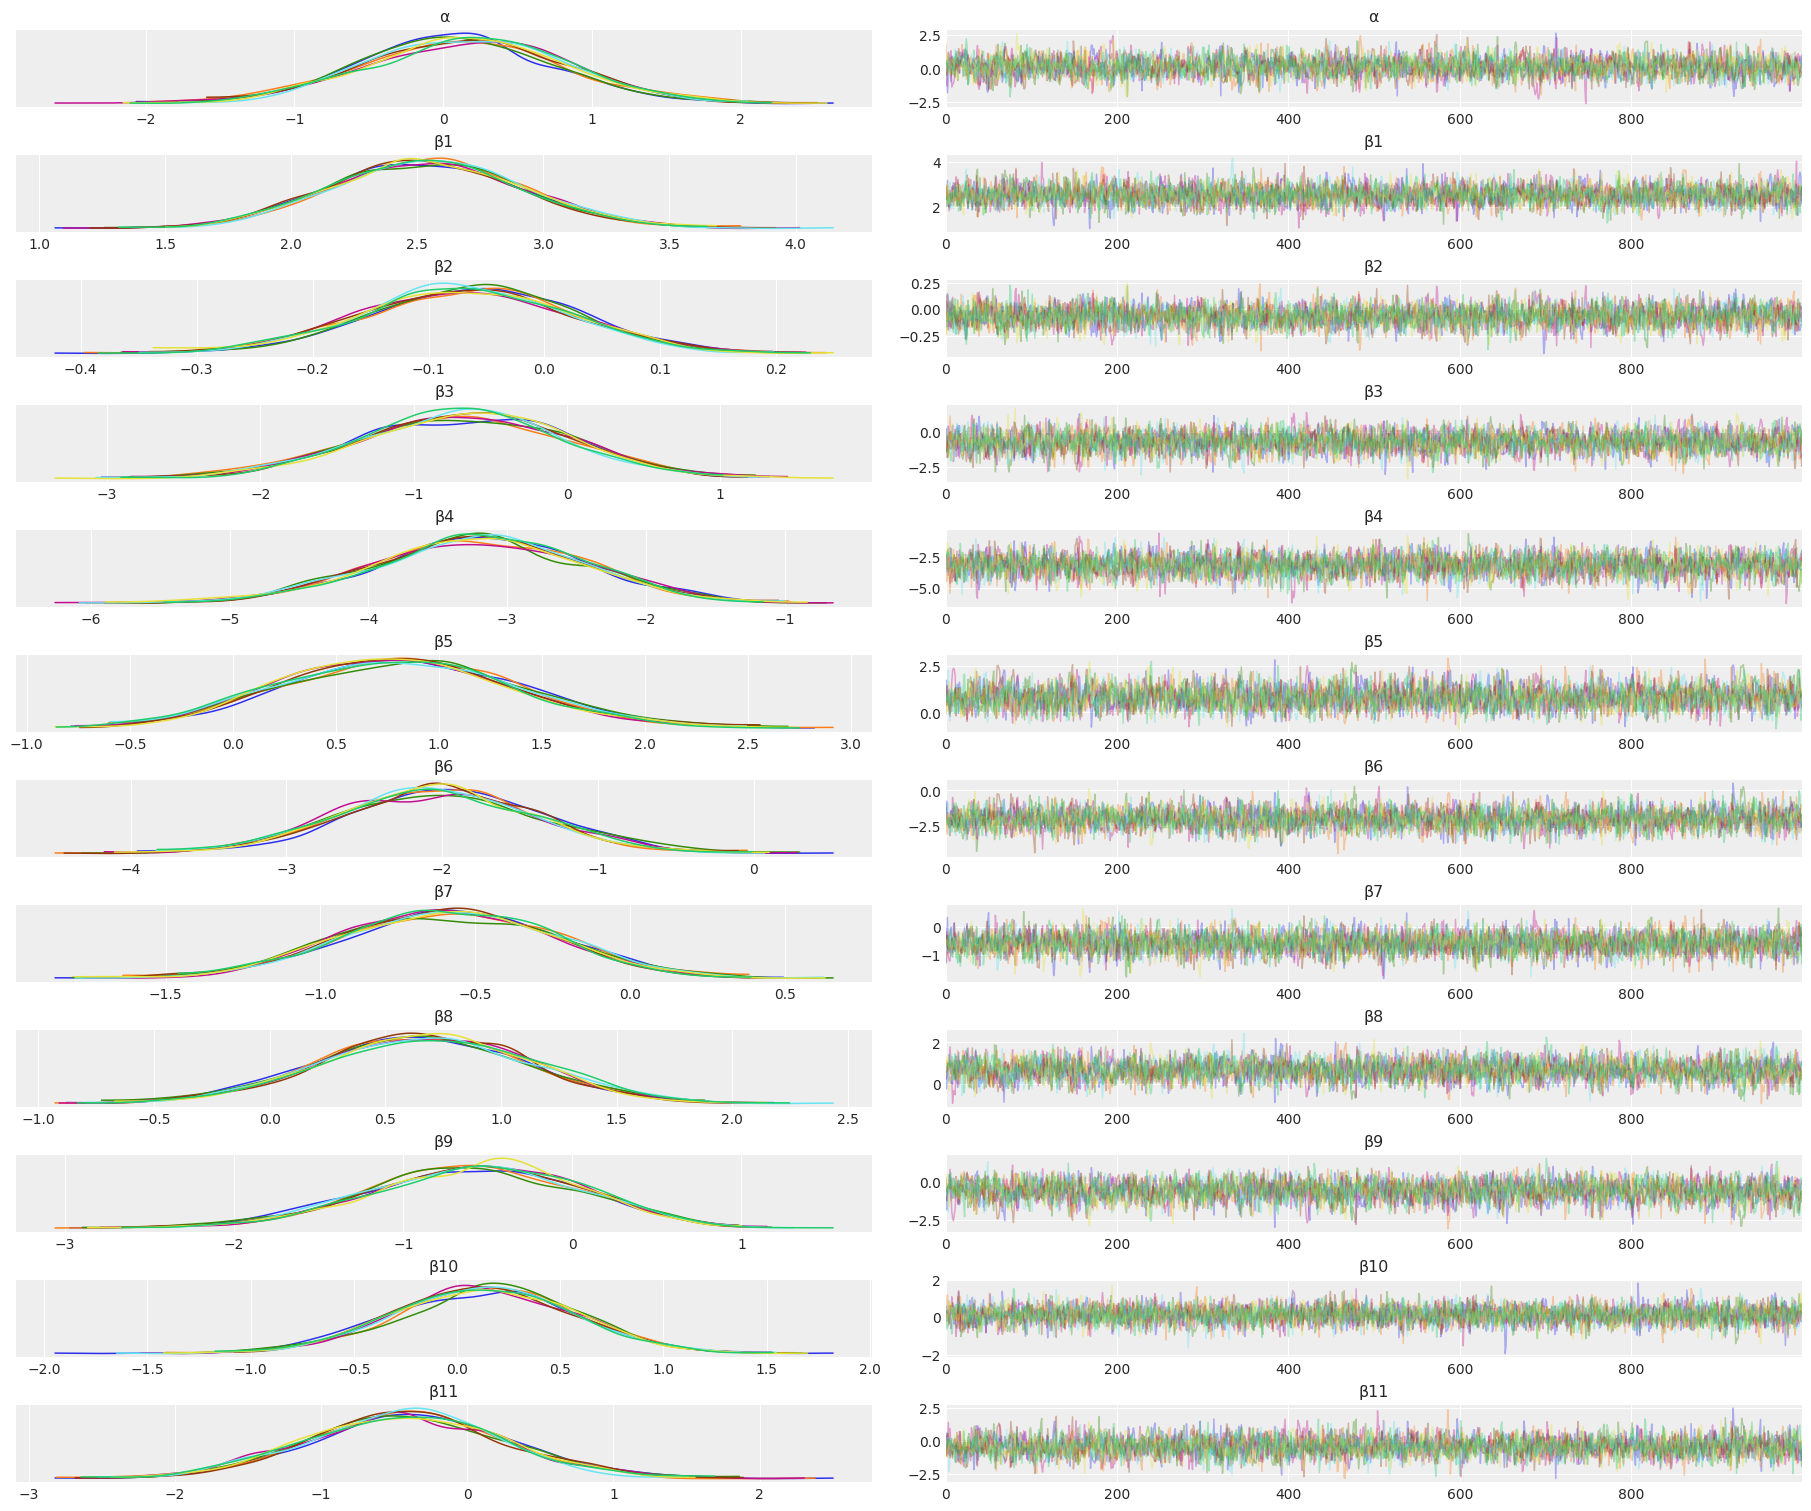

In [123]:
 az.plot_trace(sleep_trace, compact = False, var_names = ['α','β1','β2','β3','β4', 'β5', 'β6', 'β7', 'β8', 'β9', 'β10', 'β11'], figsize = (18,15));

In [124]:
az.summary(sleep_trace, var_names= ['α','β1','β2','β3','β4', 'β5', 'β6', 'β7', 'β8', 'β9', 'β10', 'β11'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.134,0.674,-1.107,1.431,0.011,0.008,3780.0,4524.0,1.0
β1,2.539,0.384,1.833,3.261,0.006,0.004,4570.0,5546.0,1.0
β2,-0.067,0.091,-0.233,0.105,0.001,0.001,4814.0,5064.0,1.0
β3,-0.684,0.685,-1.978,0.582,0.010,0.007,4881.0,5056.0,1.0
β4,-3.206,0.769,-4.626,-1.751,0.011,0.008,4997.0,5122.0,1.0
β5,0.813,0.572,-0.232,1.925,0.009,0.007,3979.0,4651.0,1.0
β6,-2.027,0.650,-3.225,-0.766,0.010,0.007,4436.0,5045.0,1.0
β7,-0.587,0.345,-1.247,0.036,0.005,0.003,5225.0,4724.0,1.0
β8,0.666,0.453,-0.182,1.525,0.007,0.005,4237.0,4893.0,1.0
β9,-0.591,0.631,-1.778,0.558,0.010,0.007,3973.0,4514.0,1.0


In [125]:
# posterior predictions
sleep_pp = pm.sample_posterior_predictive(sleep_trace, model = main_eff_model, random_seed = random_seed)

<Axes: title={'center': 'Y1 / Y1'}>

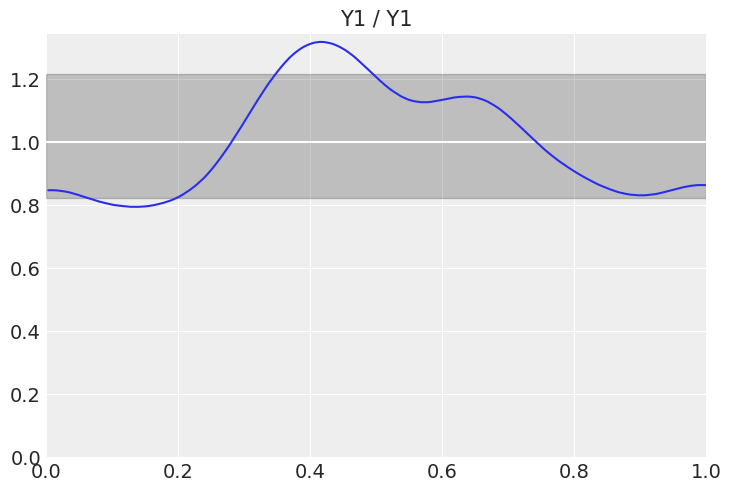

In [126]:
# bayesian p value
az.plot_bpv(sleep_pp)

<Axes: xlabel='Y1 / Y1'>

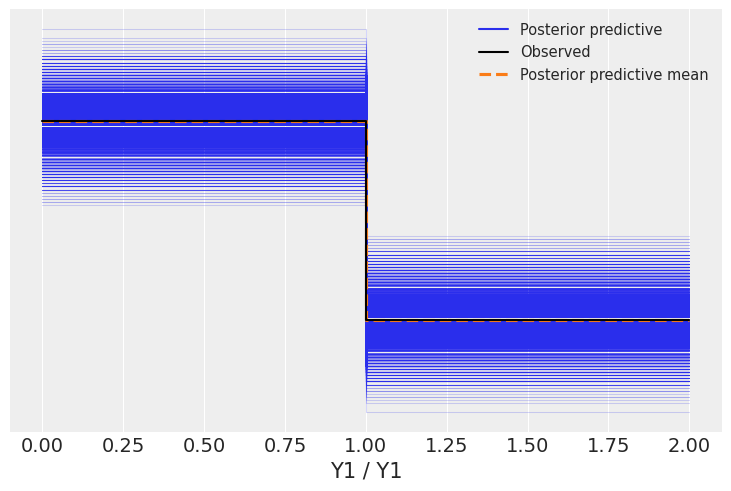

In [127]:
az.plot_ppc(sleep_pp)

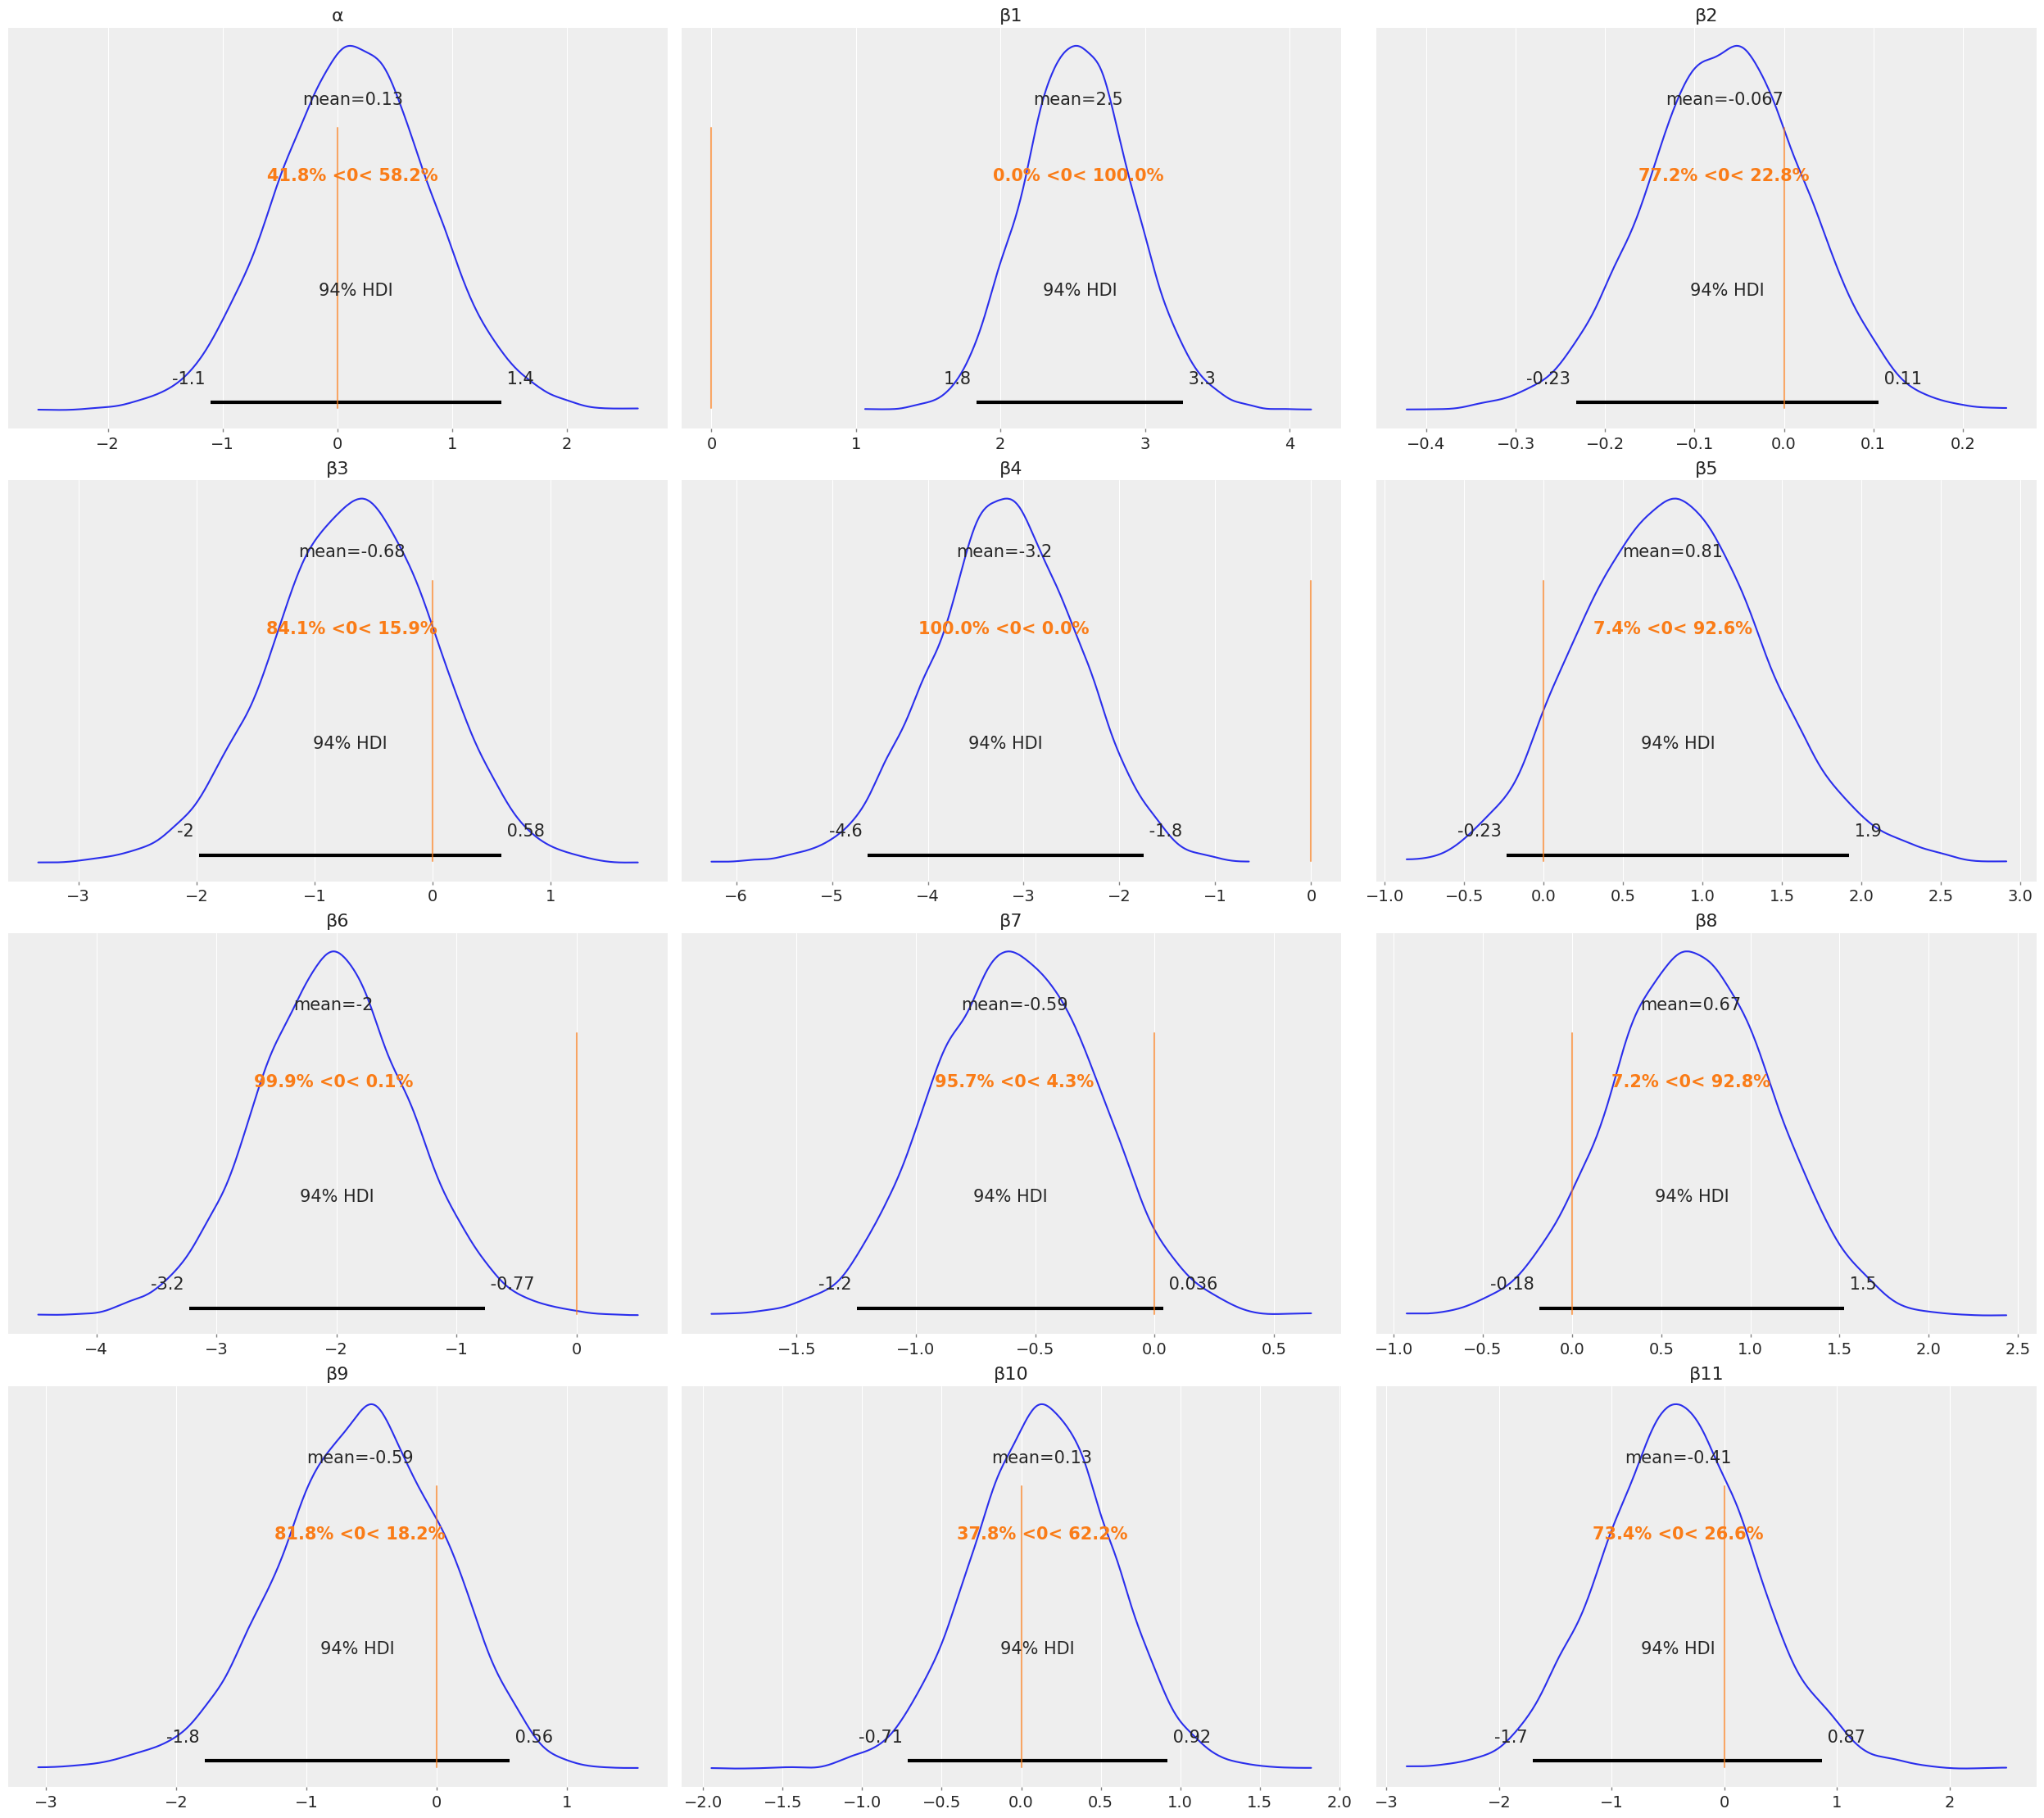

In [128]:
az.plot_posterior(sleep_trace,var_names=['α','β1','β2','β3','β4', 'β5', 'β6', 'β7', 'β8', 'β9', 'β10', 'β11'], ref_val = 0,);

<ipython-input-35-79d232d1214e>:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


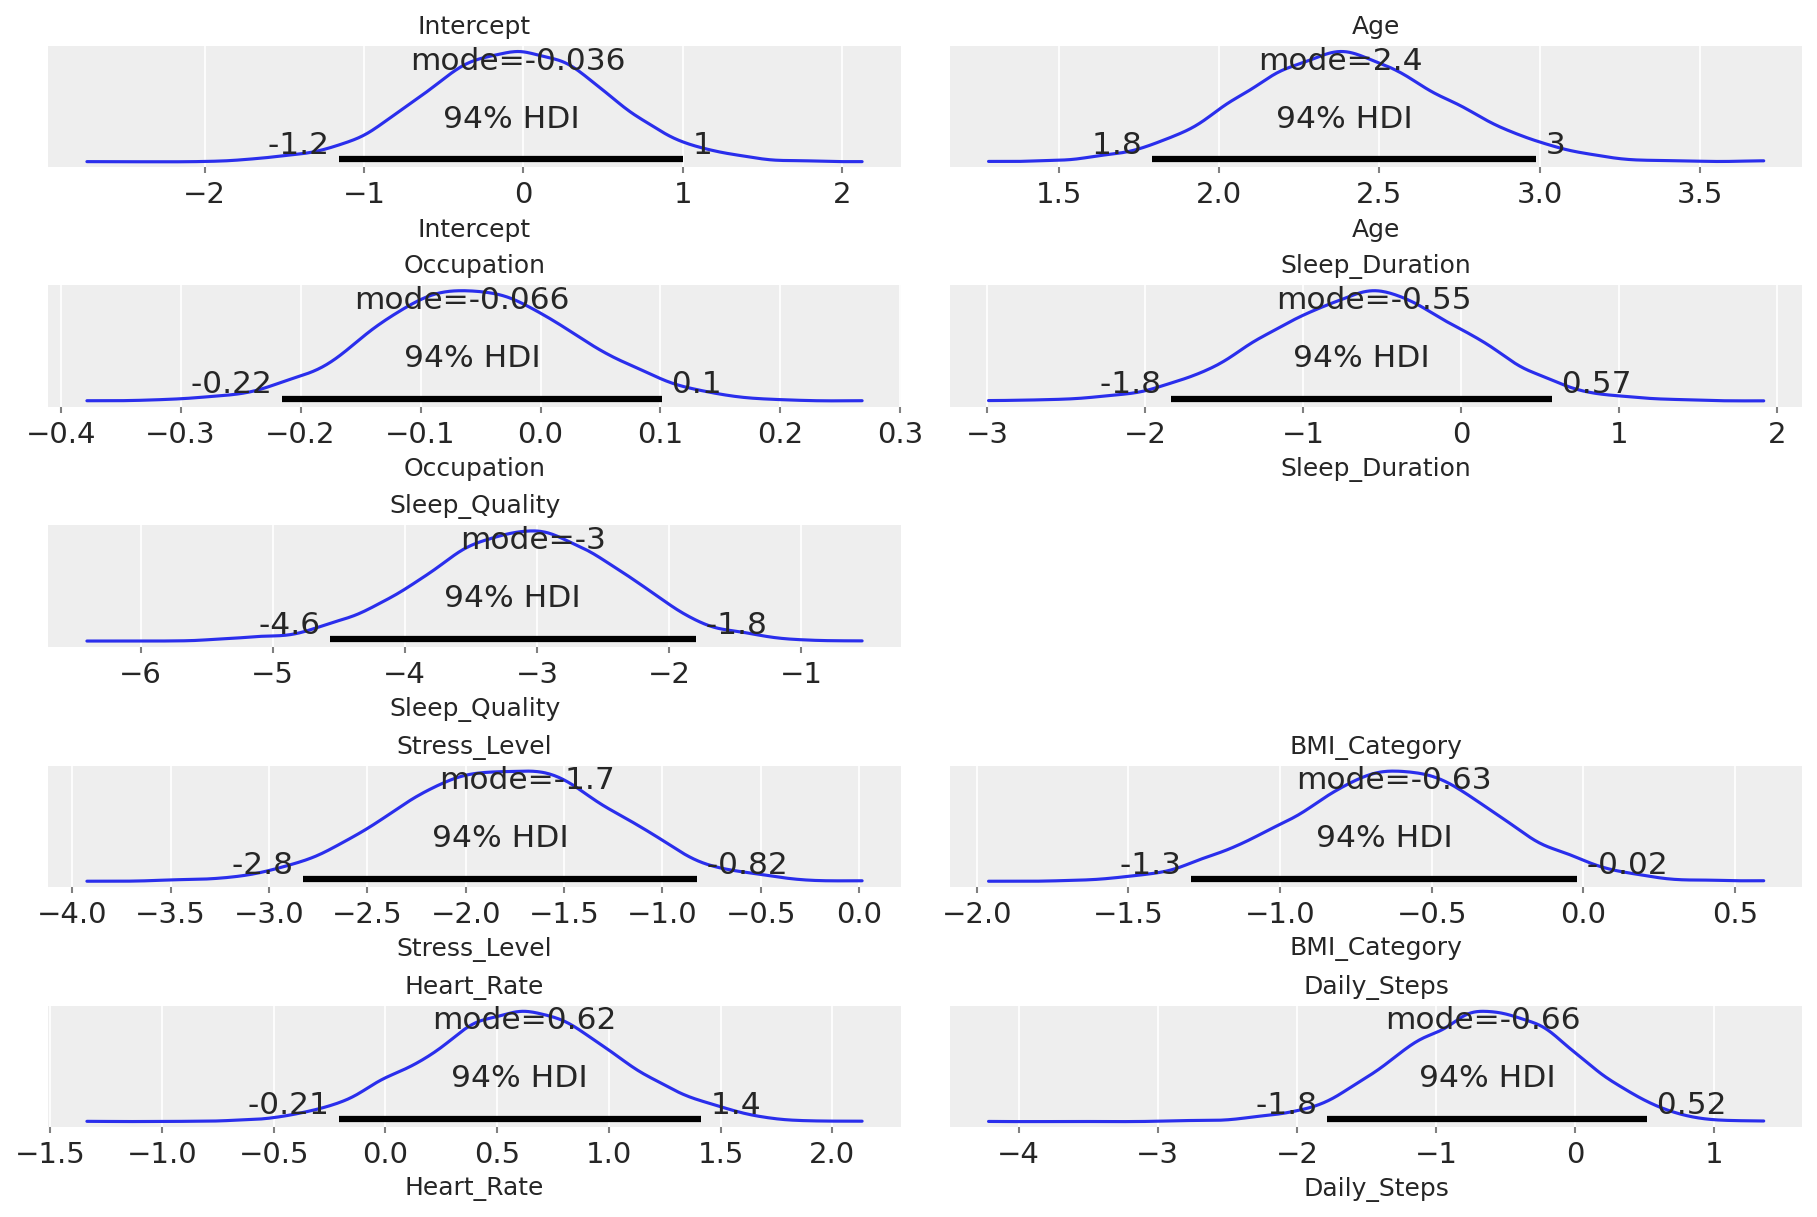

In [ ]:
# Plot posteriors with HDI and variable name

all_predictors = ['Age', 'Occupation', 'Sleep_Duration', 'Sleep_Quality', 'Physical_Activity_Level',
                  'Stress_Level', 'BMI_Category', 'Heart_Rate', 'Daily_Steps', 'BP_Category', 'Gender']
parameters = ['α','β1','β2','β3','β4', 'β5', 'β6', 'β7', 'β8', 'β9', 'β10', 'β11']

fig, axes = plt.subplots(5,2, figsize=(12,8), dpi=150)
for ax, estimate, title, xlabel in zip(fig.axes,
                                      (sleep_trace.posterior[i] for i in parameters),
                                       ['Intercept'] + all_predictors,
                                        ['Intercept'] + all_predictors):
    pm.plot_posterior(estimate, point_estimate='mode', ax=ax)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)

fig.delaxes(axes[2,1])
plt.tight_layout()